### [E16] 다음에 볼 영화예측하기

#### Session Based Recommendation?
- 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천

- 세션(Session)이란, 유저가 서비스를 이용하면서 발생하는 중요한 정보를 서버쪽에 저장한 데이터이다.


In [1]:
# 한국어 폰트 설치를 확인합니다.  
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 

In [2]:
import pandas as pd
import tensorflow as tf

import datetime as dt
from pathlib import Path
import os

import numpy as np
import warnings
warnings.filterwarnings('ignore')

print(pd.__version__)
print(tf.__version__)

1.3.3
2.6.0


### Data load

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
from datetime import timedelta

start=pd.to_datetime("1970-01-01 00:00:00")

def change_time(x):
    return start+timedelta(seconds=x)

data["Time"]=data["Time"].map(lambda x: change_time(x))

In [5]:
print("유저수:",data['UserId'].nunique(),"/아이템수:", data['UserId'].nunique())

유저수: 6040 /아이템수: 6040


- 영화별점을 1점 혹은 2점 줬다는 것은 마음에 안든다는 점을 적극적으로 나타내기 위해서 일부러 로그인을 해서 입력을 했다는 것으로 보인다. 이건 유저가 선호하지 않는 아이템이라는 증거이므로 3미만의 rating은 제거한다.

In [6]:
data=data[data["Rating"]>=3]

### session length

In [7]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       116
3        46
4        19
5       143
       ... 
6036    708
6037    189
6038     18
6039    119
6040    276
Length: 6039, dtype: int64

In [8]:
print("세션길이의 중앙값:",session_length.median(), "/ 세션길이의 평균:",session_length.mean())

세션길이의 중앙값: 81.0 / 세션길이의 평균: 138.51266766020865


In [9]:
print("세션길이의 최소값:",session_length.min(),"/ 세션길이의 최대값:", session_length.max())

세션길이의 최소값: 1 / 세션길이의 최대값: 1968


In [10]:
print("99.9%세션의 길이:",session_length.quantile(0.999))

99.9%세션의 길이: 1118.8860000000013


In [11]:
long_session = session_length[session_length==session_length.max()].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,2000-08-03 20:09:52
697168,4169,2617,4,2000-08-03 20:09:52
697185,4169,2628,4,2000-08-03 20:09:52
697219,4169,2653,4,2000-08-03 20:09:52
697275,4169,423,3,2000-08-03 20:09:52
...,...,...,...,...
697055,4169,3207,3,2002-06-15 20:23:26
695958,4169,3413,3,2002-06-15 20:33:11
695702,4169,1413,3,2002-06-15 21:03:51
697358,4169,494,4,2002-06-15 21:16:00


In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1       0.000166
7       0.000331
9       0.000994
10      0.001159
11      0.001987
          ...   
1029    0.998013
1034    0.998344
1054    0.998510
1106    0.998675
1116    0.998841
Length: 636, dtype: float64

### 세션길이 기준 하위 99.9%까지의 분포 누적합 시각화

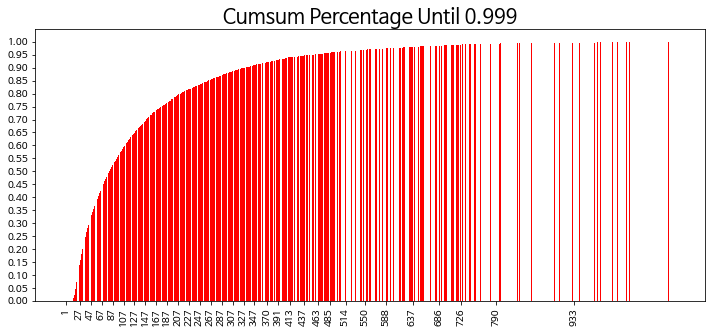

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index[::20], rotation=90)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### session time

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


### Data cleansing

In [15]:
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [16]:
data = cleanse_recursive(data, shortest=3, least_click=5)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [17]:
u=data.groupby('UserId').size()
u[u<2] # 2보다 작은 사이즈는 사라졌다.

Series([], dtype: int64)

In [18]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('Time')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['Time'].isin(session_in_train)]
    after_date = data[data['Time'].isin(session_in_test)]
    return before_date, after_date

In [19]:
tr, test = split_by_date(data, n_days=90)
tr, val = split_by_date(tr, n_days=90)

In [20]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 828507
	 Sessions: 6037
	 Items: 3307
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-09-01 04:20:59

* valid Set Stats Info
	 Events: 3537
	 Sessions: 228
	 Items: 1540
	 First Time : 2002-09-01 19:41:39
	 Last Time : 2002-11-30 13:47:32

* test Set Stats Info
	 Events: 3745
	 Sessions: 230
	 Items: 1558
	 First Time : 2002-11-30 20:24:52
	 Last Time : 2003-02-28 17:49:50



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [23]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Data Pipeline

In [24]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to UserId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each User IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [25]:
tr_dataset = SessionDataset(tr) # SessionDataset 객체
tr_dataset.df.head(10)          # df는 data/ 즉, 데이터프레임

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [26]:
print("각 세션이 시작된 인덱스: ",tr_dataset.click_offsets[:10])
print("각 세션을 인덱싱한 np.array: ",tr_dataset.session_idx[:10])

각 세션이 시작된 인덱스:  [  0  53 169 215 234 377 446 477 609 707]
각 세션을 인덱싱한 np.array:  [0 1 2 3 4 5 6 7 8 9]


### SessionDataLoader
- SessionDataset 객체를 받아서 Session - Parallel mini-batch를 만드는 클래스

In [27]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):  # 모델 input, label, session이 끝나는 위치를 yield
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [28]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [29]:
iter_ex = iter(tr_data_loader)

In [30]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


In [31]:
tr_data_loader.initialize()

(array([  0,  53, 169, 215], dtype=int32),
 array([ 53, 169, 215, 234], dtype=int32),
 array([], dtype=float64),
 3,
 False)

### Evaluating Metric
- MRR@K:
- Recall@K:

In [32]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [33]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [34]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [35]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

### Model Training

In [36]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)
    acc={"Recall@20":[], "MRR@20":[]}

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
        acc["Recall@20"].append(val_recall)
        acc["MRR@20"].append(val_mrr)        
    return acc


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [37]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

### 0. 기본모델
-  batch size=128/ epochs = 10

In [38]:
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=8, k=20)
model = create_model(args)
acc_=train_model(model, args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout (Dropout)            (128, 50)                 0         
_________________________________________________________________
dense (Dense)                (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  16%|█▌        | 4/25 [00:02<00:12,  1.63it/s]


	 - Recall@20 epoch 1: 0.064453
	 - MRR@20    epoch 1: 0.016104



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.79it/s]


	 - Recall@20 epoch 2: 0.074219
	 - MRR@20    epoch 2: 0.019621



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.79it/s]


	 - Recall@20 epoch 3: 0.074219
	 - MRR@20    epoch 3: 0.018384



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.83it/s]


	 - Recall@20 epoch 4: 0.082031
	 - MRR@20    epoch 4: 0.018190



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.80it/s]


	 - Recall@20 epoch 5: 0.085938
	 - MRR@20    epoch 5: 0.021275



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.83it/s]


	 - Recall@20 epoch 6: 0.085938
	 - MRR@20    epoch 6: 0.022753



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.82it/s]


	 - Recall@20 epoch 7: 0.087891
	 - MRR@20    epoch 7: 0.022227



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.80it/s]

	 - Recall@20 epoch 8: 0.089844
	 - MRR@20    epoch 8: 0.021984



### 첫번째모델 테스트

In [39]:
test_model(model, args,test)

Evaluation:  15%|█▍        | 4/27 [00:02<00:12,  1.90it/s]

	 - Recall@20: 0.123047
	 - MRR@20: 0.042606



학습이 너무 느린 것 같다. 학습율을 늘려봐야겠다.

### 1. 두번째 모델
- lr=0.005

In [40]:
args2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.005, epochs=8, k=20)
model2 = create_model(args2)
acc_2=train_model(model2, args2)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(128, 1, 3307)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    503850    
_________________________________________________________________
dropout_1 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_1 (Dense)              (128, 3307)               168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  16%|█▌        | 4/25 [00:02<00:12,  1.67it/s]


	 - Recall@20 epoch 1: 0.078125
	 - MRR@20    epoch 1: 0.025480



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.81it/s]


	 - Recall@20 epoch 2: 0.080078
	 - MRR@20    epoch 2: 0.029858



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.83it/s]


	 - Recall@20 epoch 3: 0.087891
	 - MRR@20    epoch 3: 0.031631



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.80it/s]


	 - Recall@20 epoch 4: 0.091797
	 - MRR@20    epoch 4: 0.034438



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.83it/s]


	 - Recall@20 epoch 5: 0.093750
	 - MRR@20    epoch 5: 0.034381



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.79it/s]


	 - Recall@20 epoch 6: 0.089844
	 - MRR@20    epoch 6: 0.032240



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.87it/s]


	 - Recall@20 epoch 7: 0.095703
	 - MRR@20    epoch 7: 0.032835



Evaluation:  16%|█▌        | 4/25 [00:02<00:11,  1.80it/s]

	 - Recall@20 epoch 8: 0.095703
	 - MRR@20    epoch 8: 0.033519



### 두번째 모델 테스트

In [41]:
test_model(model2, args2,test)

Evaluation:  15%|█▍        | 4/27 [00:02<00:12,  1.87it/s]

	 - Recall@20: 0.121094
	 - MRR@20: 0.038189



첫번째 모델의  Recall@20: 0.12109/ MRR@20: 0.046490 이었던 것과 비교하면 Recall@20과 MRR@20모두 성능이 나빠졌다. 학습율은 차라리 처음 모델대로 가던게 나았나보다.

## 2. 세번째 모델

In [42]:
args3 = Args(tr, val, test, batch_size=64, hsz=50, drop_rate=0.5, lr=0.001, epochs=8, k=20)
model3 = create_model(args3)
acc_3=train_model(model3, args3)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(64, 1, 3307)]           0         
_________________________________________________________________
GRU (GRU)                    [(64, 50), (64, 50)]      503850    
_________________________________________________________________
dropout_2 (Dropout)          (64, 50)                  0         
_________________________________________________________________
dense_2 (Dense)              (64, 3307)                168657    
Total params: 672,507
Trainable params: 672,507
Non-trainable params: 0
_________________________________________________________________


Evaluation:  45%|████▌     | 23/51 [00:06<00:08,  3.36it/s]


	 - Recall@20 epoch 1: 0.109375
	 - MRR@20    epoch 1: 0.024552



Evaluation:  45%|████▌     | 23/51 [00:06<00:07,  3.51it/s]


	 - Recall@20 epoch 2: 0.120245
	 - MRR@20    epoch 2: 0.032826



Evaluation:  45%|████▌     | 23/51 [00:06<00:07,  3.50it/s]


	 - Recall@20 epoch 3: 0.133152
	 - MRR@20    epoch 3: 0.035513



Evaluation:  45%|████▌     | 23/51 [00:06<00:08,  3.43it/s]


	 - Recall@20 epoch 4: 0.133152
	 - MRR@20    epoch 4: 0.034558



Evaluation:  45%|████▌     | 23/51 [00:06<00:08,  3.50it/s]


	 - Recall@20 epoch 5: 0.139266
	 - MRR@20    epoch 5: 0.034994



Evaluation:  45%|████▌     | 23/51 [00:06<00:08,  3.49it/s]


	 - Recall@20 epoch 6: 0.139946
	 - MRR@20    epoch 6: 0.035214



Evaluation:  45%|████▌     | 23/51 [00:06<00:08,  3.44it/s]


	 - Recall@20 epoch 7: 0.136549
	 - MRR@20    epoch 7: 0.035740



Evaluation:  45%|████▌     | 23/51 [00:06<00:07,  3.54it/s]

	 - Recall@20 epoch 8: 0.136549
	 - MRR@20    epoch 8: 0.037265



### 세번째 모델 테스트

In [43]:
test_model(model3, args3,test)

Evaluation:  41%|████      | 22/54 [00:06<00:09,  3.51it/s]

	 - Recall@20: 0.133523
	 - MRR@20: 0.040990



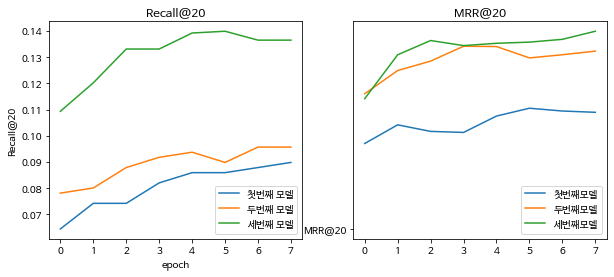

In [45]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(acc_["Recall@20"],label="첫번째 모델")
plt.plot(acc_2["Recall@20"],label="두번째 모델")
plt.plot(acc_3["Recall@20"],label="세번째 모델")

plt.legend()
plt.title("Recall@20")
plt.ylabel("Recall@20")
plt.xlabel("epoch")

plt.subplot(1,2,2)
plt.plot(acc_["MRR@20"], label="첫번째모델")
plt.plot(acc_2["MRR@20"], label="두번째모델")
plt.plot(acc_3["MRR@20"], label="세번째모델")

plt.legend()
plt.title("MRR@20")

plt.show()

### 회고
- Session Based Recommendation 시스템을 가정하고 만들어진 데이터셋이 아니라서 성능이 좋지 않게 나온 것 같다. dropout rate를 